# Bayesian analysis of the effects of Daylight Savings Time (DST) adjustment on the incidence rate of Acute Myocardinal Infarction (AMI)

### Background

Various papers and famous sleep researchers claim that the DST adjustment causes an increase in AMI count during the following days or weeks, attributing this increase to the reduction in sleep or the disturbance in the circadian rhythm.

### Methods

I believe this perceived increase is merely a statistical artifact resulting from low sample size and potentially publication bias, despite it being "statistically significant". This notebook investigates whether using Bayes factors with consistently and formally stated null and alternative hypotheses confirms the findings of the studies (which used frequentist hypothesis tests) and the meta-analysis (which combined the results using a "random-effect generic inverse variance approach", as described by the Cochrane Handbook).

I have so far analyzed data from the following sources:
 - Sandhu et al. (2014) _Daylight savings time and myocardial infarction_. Open Heart. [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4189320/) (I chose this paper as it brought the issue to my attention.)
 - Kirchberger et al. 2015. _Are daylight saving time transitions associated with changes in myocardial infarction incidence? Results from the German MONICA/KORA Myocardial Infarction Registry_. BMC Public Health. 2015; 15: 778. [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4535383/) (I chose this paper randomly from Manfredini2019 -- see below.)
 
I also plan to integrate evidence from all the papers mentioned in this meta-analysis:
 - Manfredini et al. (2019) _Daylight Saving Time and Acute Myocardial Infarction: A Meta-Analysis_. Journal of Clinical Medicine [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6463000/)
 
### Motivation

I fully acknowledge the role of adequate sleep, and I am undecided on the positive or negative effects of DST. However, I believe scientific reporting could use statistical methods that are both simpler, more explicit, less black-and-white, and more precise.

## Introduction

### Poisson distribution

The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event. In our case, the “event” is an AMI, and the fixed interval of time is a day. While AMIs probably don't happen at a constant rate throughout the day, the [sum of Poisson-distributed random variables](https://en.wikipedia.org/wiki/Poisson_distribution#Sums_of_Poisson-distributed_random_variables) is also Poisson-distributed, so any day's total will also be Poisson-distributed.

The distribution has a single parameter, which is a positive real number, and is often denoted $λ$. The mean (expected value) of $\text{Poisson}(λ)$ is $λ$, and the standard deviation is $\sqrt{λ}$. Its probability mass function is shown below for $λ=20$ and $λ=100$, along with an interval that covers 90% of the probability mass.

![Distribution of Poisson plots for means 20 and 100](figs/poisson-dist.svg)

If $X \sim \text{Poisson}(λ)$, meaning $X$ is a $\text{Poisson}(λ)$-distributed random variable, then the probability of $X$ having the value $k$ is

$$\mathbb P(X=k) = λ^k \frac{e^{-k}}{k!}.$$

During this re-analysis of published papers I didn’t have access to the raw data, and the papers usually reported only the sum of AMIs on a given day (e.g. Tuesday after DST change) over the period of the study (e.g. the 4 years 2010–2013). Again, the individual counts are each Poisson-distributed, so their sum is Poisson-distributed too.

## Analysis

In the beginning I consider two competing hypotheses: the null hypothesis assumes no change in the expected AMI daily count on the week following DST adjustments. (This is what [McShane et al. (2019)](https://www.tandfonline.com/doi/full/10.1080/00031305.2018.1527253) call “the generally implausible and uninteresting sharp point null hypothesis of zero effect and zero systematic error”.) Under the alternative hypothesis, the expected AMI count increases by $+X\%$ on the following Monday, by $+0.8X\%$ on Tuesday, and so on until a $+0.2X\%$ increase on Friday. (Prior to these experiments, it feels _very_ unlikely that there would be any effect on Friday, but one paper measured effects on the 2 and 4 weeks following DST adjustment, so at least someone considered it before me.) Later we will extend the model to be the mixture of a non-zero effect in the following 1...5 weekdays instead of the fixed 5 days.

Although in the absence of data I would bet much more favorably on the null hypothesis (meaning my prior would have a much higher weight on $H_0$), in this analysis I will use 50-50% prior probabilities. Later we will see that the posterior probabilities can be easily recalculated for different priors – such as that we get from [soliciting the opinion of experts](https://www.tandfonline.com/doi/full/10.1080/00031305.2018.1518265) who haven't read this study, or that from a betting market. In the presence of large independent datasets – which humanity should have on this topic – the choice of prior doesn’t matter and is dominated by the data (under some very mild assumptions).

### Notation

For a particular study, $m_i$ denotes the AMI counts as predicted by the trend model on day $i$ (with $i = 1,\,\ldots,\,5$ for Monday, $\ldots$, Friday after the DST change), and $o_i$ denotes the observed count on day $i$. Finally, $\mathcal D$ denotes the whole dataset, i.e. all the observations $\{o_1,\ldots,o_5\}$.

### Null hypothesis

Our null hypothesis assumes that the observed count on day $i$ is sampled from a Poisson distribution with parameter $\lambda_i
$, with independent distributions for the 5 days. The likelihood of observed count $o_i$ on day $i$ is

$$\mathbb P(o_i \text{ AMIs on day } i\ |\ H_0) =
e^{-\lambda_i} \frac{\lambda_i^{o_i}}{o_i!},$$

so the likelihood of all of the data under the null hypothesis is equal to

$$\mathbb P(\mathcal D | H_0) = \prod_{i=1}^5 \mathbb P(o_i \text{ AMIs on day } i\ |\ H_0) =
\prod_{i=1}^5 e^{-\lambda_i} \frac{\lambda_i^{o_i}}{o_i!}.$$

## Alternative hypotheses

We define two alternative hypotheses: $H_1$ is that on the Monday following DST adjustment, more AMIs happen than on a regular day. Under $H_2$, the expected AMI counts increase on all days from Monday until Friday.  But by how much, specifically?

Note that the original paper did not make such estimations, because [null hypothesis significance tests](https://en.wikipedia.org/wiki/Student's_t-test#One-sample_t-test) do not require evaluating the marginal likelihood of the alternative hypothesis.

Our _prior_ expectations about the relative increase must not be defined – or even contaminated – by the actual observations; otherwise we will simply see what we want to see. We must ask: if the parameter of the Poisson distribution for day $i$ were to increase from $\lambda_i$ to $\tilde\lambda_i$, then what values could it have, and which would be more likely? (Afterwards we are going to test the assumptions we make here.) We don't expect that the new parameter is 10 times higher than the original, because we would have noticed already if 10 times more people had an infarction after a DST adjustment. A significant but plausible increase in the average AMI count would be around 20% for Monday (the first day when people need to wake up earlier), and 0% increase by Friday, expecting that the effect would taper off in a week.

Therefore, we define our prior beliefs in the alternative model about the new parameter $\tilde\lambda_1$ with a probability distribution that has support over $(\lambda_1; \inf)$, and a mean of $1.2 \lambda_1$. How do we choose the shape of the distribution? I ask my friend who's campaining for the alternative hypothesis:

- _Me_: “So are you saying you would be much less surprised to see a 1% increase in the AMI count on Monday (compared to the trend) than a 20% increase?”
- _Friend_: “No, of course not, 1% is nothing. I expect around 10-30 percent.”
- _Me_: “But probably not so crazy like a +100% increase”
- _Friend_: “Right.”
- _Me_: “Thanks for your input, your expectations will be taken seriously.”

So the prior on the Monday AMI count distributes its probability mass as such:

![Prior Monday](figs/prior_monday.svg)

- _Friend_: “But hey, what about the other days?”
- _Me_: “What about them? Do you expect that the DST change would affect those too?”
- _Friend_: “Just lemme see the data and I will tell you so.”
- _Me_: “Uh-uh, it doesn’t work that way. I apologize, but humans are notorious for being easily biased, and after having seen the data you would say a hypothesis that fits it _best_. Remember, we're not looking for a single parameter, but we’re calibrating our uncertain judgements. So, how long do you expect until the effect wears off?”
- _Friend_: “For the sake of simplicity, we can assume that the effect wears off linearly, and it has no effect by Saturday, which is on the weekend anyhow.”
- _Me_: “Alright. Fortunately, the infarction counts on neighboring days are independent (apart from exceptional cases, such as a world catastrophe), which means we can model them separately and just multiply the marginal likelihoods.
($\mathrm{Pr}[\text{data} | H_1] =
\mathrm{Pr}[\text{Mon} | H_1] \,\cdot\,\ldots\,\cdot\,\mathrm{Pr}[\text{Fri} | H_1]$) The priors you described take these forms:

![Priors Monday–Friday](figs/prior_all.svg)

“Note that as the trend changes from Monday to Friday, so does the minimum of our belief about the number of infarctions. And if a distribution is narrow, it is that much taller, so for visibility we can rescale them, resulting in the following:

![Priors Monday–Friday, rescaled](figs/prior_all_rescaled.svg)

We get such a distribution if we shift a Gamma distribution by $\lambda_1$:

$$
\tilde\lambda_1 \sim \lambda_1 + \text{Gamma}(k=0.2\lambda_1,\, \theta=1)
$$

## Code

In [9]:
%load_ext autoreload
%aimport utils, models_dst
%autoreload 1

In [10]:
import logging
from collections import defaultdict
from typing import Union, List, Dict, Mapping, Any

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from tqdm import trange

import models_dst as m
import utils

In [11]:
logger = logging.getLogger('BayesianScience')

logger.setLevel(logging.DEBUG)

## Data

In [12]:
marginal_likelihoods = defaultdict(dict)

In [13]:
data = defaultdict(lambda: {'trend': None, 'obs': None})

## Sandhu et al. (2014)

In [6]:
PAPER_ID = "Sandhu2014"

Timeline: 1 January 2010 – 15 September 2013 (3 fall and 4 spring DST changes)

> Procedural data for hospital admissions where PCI was performed in the setting of AMI between 1 January 2010 and 15 September 2013 were included in this analysis.

> In this study, 42 060 hospital admissions for AMI requiring PCI occurred during the study period. Figure 1A provides a plot of the daily PCIs performed for AMI over 1354 days included in the study period. The median daily AMI total was 31, ranging from a minimum of 14 to a maximum of 53 admissions.

**Results**

> There was no difference in the total weekly number of PCIs performed for AMI for either the fall or spring time changes in the time period analysed. After adjustment for trend and seasonal effects, the Monday following spring time changes was associated with a 24% increase in daily AMI counts (p=0.011), and the Tuesday following fall changes was conversely associated with a 21% reduction (p=0.044). No other weekdays in the weeks following DST changes demonstrated significant associations.

As I was unable to obtain the data at [Blue Cross Blue Shield of Michigan](https://bmc2.org), I estimated the number of AMI cases from the chart in Figure 3. Access to data in the years since 2013 would allow me to validate the conclusions on a three times larger sample size.

Screenshot taken of figure and analyzed with [WebPlotDigitizer](https://apps.automeris.io/wpd/).

Measurement error: 1 pixel, which is $150\text{AMI}\, /\, (517-131)\text{px} ≈ 0.4$ AMIs

Figure 3 of Sandhu et al. (2014):
![Figure 3 - AMI counts after 4 years of spring DST adjustment](figs/Sandhu2014-Figure3-Spring.png)

In [7]:
ami_obs_str = """\
0.00, 108.00
1.00, 170.00
2.00, 125.33
3.00, 122.00
4.00, 116.67
5.00, 116.67
6.00, 114.00\
"""

ami_obs = {day: round(count)
           for day, count in zip(m.WEEKDAYS, utils.parse_second_column(ami_obs_str)[1:6])}

In [8]:
list(ami_obs.values())

[170, 125, 122, 117, 117]

In [9]:
ami_obs

{'Mon': 170, 'Tue': 125, 'Wed': 122, 'Thu': 117, 'Fri': 117}

In [10]:
ami_trend_str = """\
0.00, 111.33
1.00, 138.33
2.00, 127.67
3.00, 125.33
4.00, 120.33
5.00, 120.00
6.00, 110.33\
"""

ami_trend = utils.parse_second_column(ami_trend_str)
ami_trend = {day: count
           for day, count in zip(m.WEEKDAYS, utils.parse_second_column(ami_trend_str)[1:6])}

In [11]:
ami_trend

{'Mon': 138.33, 'Tue': 127.67, 'Wed': 125.33, 'Thu': 120.33, 'Fri': 120.0}

In [12]:
data[PAPER_ID]['obs'] = ami_obs
data[PAPER_ID]['trend'] = ami_trend

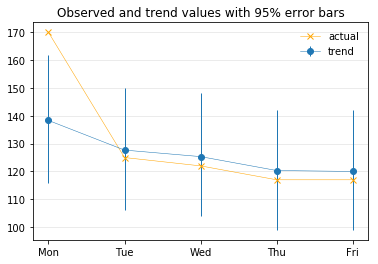

In [13]:
utils.plot_poissons_error(ami_trend, ami_obs, kw2=dict(label='actual'),
                   extra_code="plt.title('Observed and trend values with 95% error bars')");

In [14]:
H0 = m.NullHypothesis(ami_trend)
M0 = H0.marginal_likelihood(ami_obs)
print("Marginal likelihood of the null hypothesis (H0): {:.2e}".format(M0))

Marginal likelihood of the null hypothesis (H0): 1.56e-09


In [15]:
H1 = m.MondayIncreaseHypothesis(ami_trend, 0.2)
M1 = H1.marginal_likelihood(ami_obs)
print("Marginal likelihood of the “following Monday” hypothesis (H1): {:.2e}".format(M1))

Marginal likelihood of the “following Monday” hypothesis (H1): 1.79e-08


In [16]:
B01 = M0 / M1

print(f"Bayes factor for H1:  M0:M1 = 1:{1/B01 :.1f} = {B01:.4f}")

Bayes factor for H1:  M0:M1 = 1:11.5 = 0.0873


In [17]:
H2 = m.WeekdaysIncreaseHypothesis(ami_trend, 0.2)
M2 = H2.marginal_likelihood(ami_obs)
print("Marginal likelihood of the “following weekdays” hypothesis (H2): {:.2e}".format(M2))

Marginal likelihood of the “following weekdays” hypothesis (H2): 9.01e-11


In [18]:
B02 = M0 / M2

print(f"Bayes factor for H2:  M0:M2 = {B02:.1f} : 1")

Bayes factor for H2:  M0:M2 = 17.3 : 1


In [19]:
for hyp, ml in zip(['H0', 'H1', 'H2'], [M0, M1, M2]):
    marginal_likelihoods[hyp][PAPER_ID] = ml

### Sensitivity analysis

I evaluate how sensitive are the marginal likelihoods to the choice of prior. The prior is parametrized by the shape of the hyperprior (the prior on $\lambda_i$) and by the expected incidence rate. If changing these parameters within reasonable bounds doesn't cause unreasonable change in the marginal likelihood, it is considered robust. Specifically, I want to see a small change in the output (TODO – how small is small?) if I change the `expected_increase` parameter from 0.2 to 0.1 (or 0.3), or if I change the shape of the Gamma prior on $\lambda_i$ from 2.0 to 1.0.

In [20]:
%load_ext jupyter_spaces

In [21]:
%%space

def f(expected_increase, prior_shape):
    H1 = m.MondayIncreaseHypothesis(ami_trend, expected_increase, prior_shape=prior_shape)
    M1 = H1.marginal_likelihood(ami_obs)
    print(f"x={expected_increase:.1f}, y={prior_shape:.1f}  >>>  M1 = {M1:.2e}")

for x,y in [(0.2, 2.),
            (0.1, 2.),
            (0.3, 2.),
            (0.2, 1.)]:
    f(x,y)

x=0.2, y=2.0  >>>  M1 = 1.79e-08
x=0.1, y=2.0  >>>  M1 = 2.40e-08
x=0.3, y=2.0  >>>  M1 = 1.19e-08
x=0.2, y=1.0  >>>  M1 = 1.82e-08


# Kirchberger et al.

In [2]:
PAPER_ID = "Kirchberger2015"

Kirchberger et al. 2015. _Are daylight saving time transitions associated with changes in myocardial infarction incidence? Results from the German MONICA/KORA Myocardial Infarction Registry_. BMC Public Health. 2015; 15: 778. [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4535383/)

**Data**:
- AMI count: 25,499 cases of AMI
- data source: MONICA/KORA Myocardial Infarction Registry ([link](https://www.helmholtz-muenchen.de/herzschlag-info/); public data should be published yearly according to [this website](http://www.gbe-bund.de/gbe10/abrechnung.prc_abr_test_logon?p_uid=gast&p_aid=0&p_knoten=FID&p_sprache=E&p_suchstring=7014), but I did not find a link to download the dataset) 
- time period: 1 January 1985 and 31 October 2010 (26 spring and 25 fall DST changes – 2010 fall adjustment was on 31 October)
- ages: 25–74
- includes: coronary death and AMI
- location: city of Augsburg (Germany) and the two adjacent counties (about 600,000 inhabitants)
- additional variables: information on re-infarction, various medication prior to AMI, current occupation, history of hypertension, hyperlipidemia, diabetes, smoking, and obesity.
- confounders accounted for: global time trend, temperature, relative humidity, barometric pressure, and indicators for month of the year, weekday and holiday

> The final model included the following covariates: time trend and previous two day mean relative humidity as regression splines with four and two degrees of freedom, respectively, previous two day mean temperature as a linear term and day of the week as categorical variable.

> The optimized spring model [of the data from March and April, excluding the week in question] included time trend and same day mean relative humidity as regression splines with six and three degrees of freedom.

Six d.o.f. for 2 months is probably overfitting the data, even though it was the sum of 26 years. However, it shouldn’t make a predictible effect, and overall it likely had a negligible effect.

> The incidence rate ratio was assessed as observed over expected events per day and the mean per weekday and corresponding 95% confidence intervals were calculated.

However, it is not stated how the confidence intervals were calculated. It most likely wasn't a Bayesian _credible interval_ because they didn't specify the priors; so then the exact statistical test  confidence intervals would require

In [14]:
total_ami = 25_499
total_days = 9435
ami_per_day = total_ami / total_days
print("On average: {:.2f} AMI/day (stdev for the 25-year-average: {:.2f})".format(
            ami_per_day,
            st.poisson(total_ami).std() / total_days,
            st.poisson(ami_per_day).std()))

On average: 2.70 AMI/day (stdev for the 25-year-average: 0.02)


Assuming the researchers analyzed the data in an honest manner (i.e. not picking model parameters for lower prediction and more significant observed increase), and that the model didn't predict large deviations from the 2.7 AMI/day average, we can calculate Bayes factors using only the mean incidence ratios.

In [15]:
data_table_3_raw = """\
	Spring predicition model 	Autumn predicition model
Weekday	IRR [95 % CI]	IRR [95 % CI]
Sunday	0.937 [0.732; 1.141]	0.881 [0.667; 1.095]
Monday	1.207 [0.915; 1.500]	0.850 [0.572; 1.129]
Tuesday	1.185 [0.852; 1.519]	1.135 [0.861; 1.409]
Wednesday	1.075 [0.854; 1.297]	1.077 [0.832; 1.321]
Thursday	1.098 [0.809; 1.388]	1.133 [0.883; 1.383]
Friday	1.203 [0.950; 1.457]	1.244 [1.035; 1.453]
Saturday	0.850 [0.657; 1.043]	0.892 [0.657; 1.127]\
"""

In [16]:
mean_irr_spring = {}
mean_irr_autumn = {}

for line in data_table_3_raw.split('\n')[2:]:
    day_raw, spring_raw, autumn_raw = line.split('\t')
    
    day = day_raw[:3]
    f = lambda s: float(s.split(' ')[0])
    spring, autumn = map(f, (spring_raw, autumn_raw))
    mean_irr_spring[day] = spring
    mean_irr_autumn[day] = autumn

In [17]:
mean_irr_spring

{'Sun': 0.937,
 'Mon': 1.207,
 'Tue': 1.185,
 'Wed': 1.075,
 'Thu': 1.098,
 'Fri': 1.203,
 'Sat': 0.85}

Over 26 springs this adds up to:

In [18]:
year_count = 26

In [19]:
ami_trend = {day: ami_per_day * year_count for day in m.WEEKDAYS}
ami_obs = {day: round(ami_trend[day] * mean_irr_spring[day]) for day in m.WEEKDAYS}

In [20]:
data[PAPER_ID]['trend'] = ami_trend
data[PAPER_ID]['obs'] = ami_obs

In [23]:
ami_trend

{'Mon': 70.26751457339694,
 'Tue': 70.26751457339694,
 'Wed': 70.26751457339694,
 'Thu': 70.26751457339694,
 'Fri': 70.26751457339694}

In [24]:
ami_obs

{'Mon': 85, 'Tue': 83, 'Wed': 76, 'Thu': 77, 'Fri': 85}

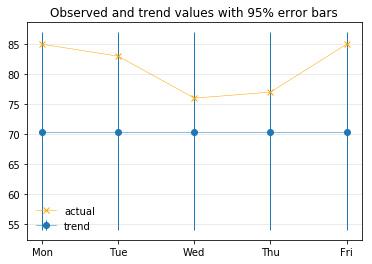

In [22]:
utils.plot_poissons_error(ami_trend, ami_obs, kw2=dict(label='actual'),
                   extra_code="plt.title('Observed and trend values with 95% error bars')");

In [31]:
H0 = m.NullHypothesis(ami_trend)
M0 = H0.marginal_likelihood(ami_obs)
print("Marginal likelihood of the null hypothesis (H0): {:.2e}".format(M0))

Marginal likelihood of the null hypothesis (H0): 1.84e-09


In [32]:
H1 = m.MondayIncreaseHypothesis(ami_trend, 0.2)
M1 = H1.marginal_likelihood(ami_obs)
print("Marginal likelihood of the “following Monday” hypothesis (H1): {:.2e}".format(M1))

Marginal likelihood of the “following Monday” hypothesis (H1): 3.86e-09


In [33]:
B01 = M0 / M1

print(f"Bayes factor for H1:  M0:M1 = 1:{1/B01 :.1f} = {B01:.4f}")

Bayes factor for H1:  M0:M1 = 1:2.1 = 0.4774


In [34]:
H2 = m.WeekdaysIncreaseHypothesis(ami_trend, 0.2)
M2 = H2.marginal_likelihood(ami_obs)
print("Marginal likelihood of the “following weekdays” hypothesis (H2): {:.2e}".format(M2))

Marginal likelihood of the “following weekdays” hypothesis (H2): 1.17e-08


In [35]:
def str_ratio(ratio):
    if ratio > 1:
        return f"{ratio:.1f} : 1"
    else:
        return f"1 : {1/ratio:.1f}"

In [36]:
B02 = M0 / M2

print("Bayes factor for H2:  M0:M2 =", str_ratio(B02))

Bayes factor for H2:  M0:M2 = 1 : 6.4


In [37]:
for hyp, ml in zip(['H0', 'H1', 'H2'], [M0, M1, M2]):
    marginal_likelihoods[hyp][PAPER_ID] = ml

## Aggregating evidence

In [38]:
def f(marginal_likelihoods: Mapping[str, Mapping[str, float]], h_null: str, h_alt: str):
    papers_both = [paper
                   for paper in marginal_likelihoods[h_null]
                   if paper in marginal_likelihoods[h_alt]]
    
    if not papers_both:
        print(f"No papers found that calculated evidence for both {h_null} and {h_alt}")
        return
    
    ml_null, ml_alt = 1., 1.
    for paper in papers_both:
        ml_null *= marginal_likelihoods[h_null][paper] 
        ml_alt *= marginal_likelihoods[h_alt][paper]
    
    if len(papers_both) == 1:
        print("Based on the evidence from the " + papers_both[0] + " paper,")
    else:
        print("Based on the combined evidence from the " + " and ".join(papers_both) + " papers,")

    print(" the Bayes factor for {} vs {} is {}".format(
            h_null, h_alt,
            str_ratio(ml_null/ml_alt)))

In [39]:
f(marginal_likelihoods, "H0", "H1")

Based on the combined evidence from the Sandhu2014 and Kirchberger2015 papers,
 the Bayes factor for H0 vs H1 is 1 : 24.0


In [40]:
f(marginal_likelihoods, "H0", "H2")

Based on the combined evidence from the Sandhu2014 and Kirchberger2015 papers,
 the Bayes factor for H0 vs H2 is 2.7 : 1


## Calculating posterior probabilities without multiple hypotheses

In this model, we place 50-50% of the prior probability mass of either being zero effect, or there being an increase in AMI counts (under the hierarchical “Weekday Model”), where the relative increase has a weakly informative Gamma prior on it.

We calculate the likelihood of the parameter values (based on the different sets of observations), which can be easily combined with the prior: multiply the prior with the likelihood, normalize it for the parameter, and there you have your posterior.

TODO: describe the hierarchical weekday model

In [41]:
expected_increase = 0.2

In [53]:
paper = "Sandhu2014"
model = m.WeekdaysModel(data[paper]['trend'], expected_increase)

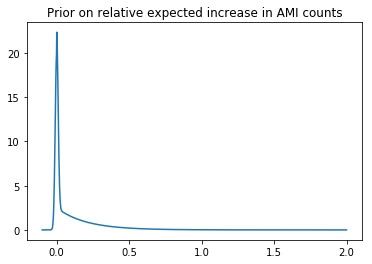

In [133]:
prior = model.prior()
plt.plot(model.param_space, prior)
plt.title('Prior on relative expected increase in AMI counts')
plt.show()

In [132]:
print("95% central credible interval (prior): [{x[0]:+.2f}%, {x[1]:+.2f}%]"
          .format(x=[y*100 for y in utils.central_credible_interval(model.param_space, prior, 0.05)]))

95% central credible interval (prior): [-1.59%, +59.58%]


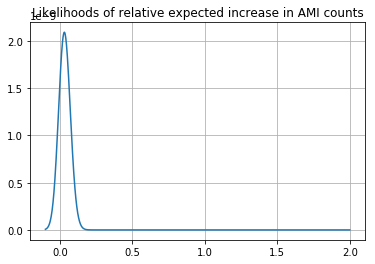

In [59]:
likelihood = model.likelihood(data[paper]['obs'])
plt.plot(model.param_space, likelihood)
plt.title('Likelihoods of relative expected increase in AMI counts')
plt.grid(True)
plt.show()

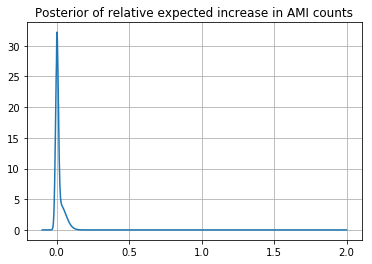

In [136]:
posterior = model.posterior(data[paper]['obs'])
plt.plot(model.param_space, posterior)
plt.title('Posterior of relative expected increase in AMI counts')
plt.grid(True)
plt.show()

In [137]:
print("95% central posterior interval: [{x[0]:+.2f}%, {x[1]:+.2f}%]"
          .format(x=[y*100 for y in utils.central_credible_interval(model.param_space, posterior, 0.05)]))

95% central posterior interval: [-1.59%, +8.71%]


In [138]:
# TODO: include likelihood of Kirchberger paper

## Further questions

**Q1.** What are the odds that there is a number of days that will have p-value less than 0.05?

The fact that every study has a separate time frame for their hypothesis, e.g. the 3/4/7/14/28 days following DST adjustment suggests that these hypotheses were made after the fact, not inspired by previous research.

Kirchberger2015:
> Overall, no significant changes of AMI risk during the first 3 days or 1 week after the transition to and from DST were found.

**Q2.** What are the odds that there will be a particular variable which makes it stick out like a sore thumb (just by random chance)? It's a function of the size of those strata: the smaller the stratum, the more likely there is an outlier. 

Kirchberger2015 (emphasis mine):
> However, subgroup analyses on the spring transition revealed significantly increased risks for men in the first 3 days after transition (RR 1.155, 95 % CI 1.000–1.334) and for persons who **took angiotensine converting enzyme (ACE) inhibitors** prior to the AMI (3 days: RR 1.489, 95 % CI 1.151–1.927; 1 week: RR 1.297, 95 % CI 1.063–1.582). After the clock shift in autumn, patients with a prior infarction had an increased risk to have a re-infarction (3 days: RR 1.319, 95 % CI 1.029–1.691; 1 week: RR 1.270, 95 % CI 1.048–1.539).

**Q3.** How are Bayes factors distributed under different values of $θ$ and N?

## Check before publishing

- Percentage signs in "$+X\%$"

## TODO

- Split into two versions: one only the facts, one the whole analysis with details.